# A/B тест

Эксперимент проходил с 2022-05-24 по 2022-05-30 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

* Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
* Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
* Опишите потенциальную ситуацию, когда такое изменение могло произойти.
* Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

Импортируем библиотеки.

In [1]:
#импорт библиотек
import pandahouse
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

Настроим подключение к ClickHouse

In [2]:
#параметры соединения с clickhouse
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

#SQL запрос 
q = """SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220620.feed_actions 
WHERE toDate(time) between '2022-05-24' and '2022-05-30'
    and exp_group in (1,2)
GROUP BY exp_group, user_id"""

Создадим базу данных.

In [3]:
#получение данных из clickhouse
df = pandahouse.read_clickhouse(q, connection=connection)

#вывод первых пяти строк данных
print(df.head())

   exp_group  user_id  likes  views       ctr
0          1   109963      3     15  0.200000
1          1    26117     32    141  0.226950
2          1   138232     18     73  0.246575
3          1    26295     33    122  0.270492
4          1    18392      7     32  0.218750


## Гистограмма.

Нарисуем гистограммы распределений.

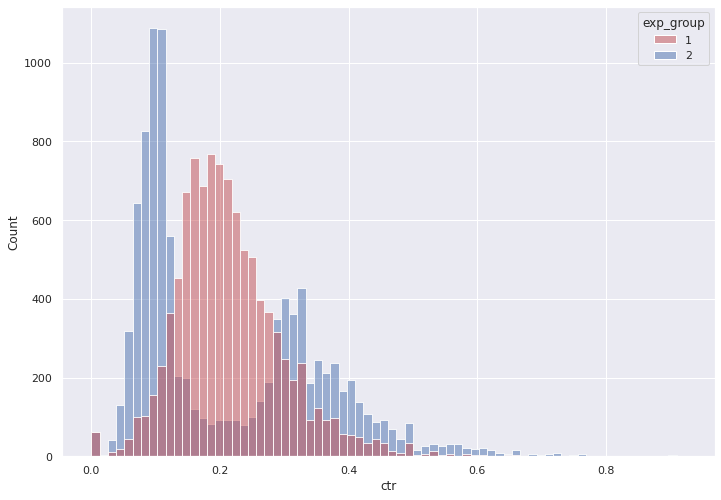

In [4]:
#установка размера гистограммы
sns.set(rc={'figure.figsize':(11.7,8.27)})

#отрисова гистограммы распределений ctr в группах 1 и 2
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

В контрольной группе 1 распределение CTR в целом достаточно сильно похоже на нормальное. Распределение в группе 2 очень сильно отличается. На гистограмме появлявилось 2 пика. Визуально выглядит так, что результат в группе 2 ухудшился.

## Тесты

### Т-тест

Распределение в тестовой группе выглядит странно. Оно очень сильно отличается от нормального.Врядли Т-тест даст адекватный результат. Однако в целях тестирования - проведем его.

Нулевая гипотеза: $H_0:\mu_1 = \mu_2$

Альтернативная гипотеза: $H_1:\mu_1 \neq \mu_2$

In [5]:
#Т-тест для групп 1-2 по ctr 
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

Т-тест указывает нам, что мы не можем отвергнуть нулевую гипотезу. Однако из-за особенностей Тестового распределения лучше удостовериться другим тестом. Попробуем Т-тест на сглаженном CTR

### Т-тест на сглаженном CTR

Сглаженный CTR.
$$
smoothedCTR_u = \frac{views_u + \alpha * globalCTR}{clicks_u+\alpha}
$$

Подготовим дополнительные переменные.

In [6]:
#вычисление global_ctr
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

Подготовим функцию для вычисления сглаженного CTR.

In [7]:
def get_smothed_ctr(user_likes, user_views, exp_group, global_ctr_1, global_ctr_2, alpha):
    '''
    Функция на вход получает лайки пользователя, просмотры пользователя, номер группы,
            global_ctr для каждой группы и коэффициент альфа
    Возвращает итог подсчета сглаженного CTR для каждой группы
    '''
    if exp_group == 1:
        global_ctr = global_ctr_1
    else:
        global_ctr = global_ctr_2
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

Посчитаем сглаженный CTR

In [8]:
#добавим стольбец со сглаженным CTR
df['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], x['exp_group'], global_ctr_1, global_ctr_2, 5), axis=1)

Нарисуем гистограмму сглажженого CTR

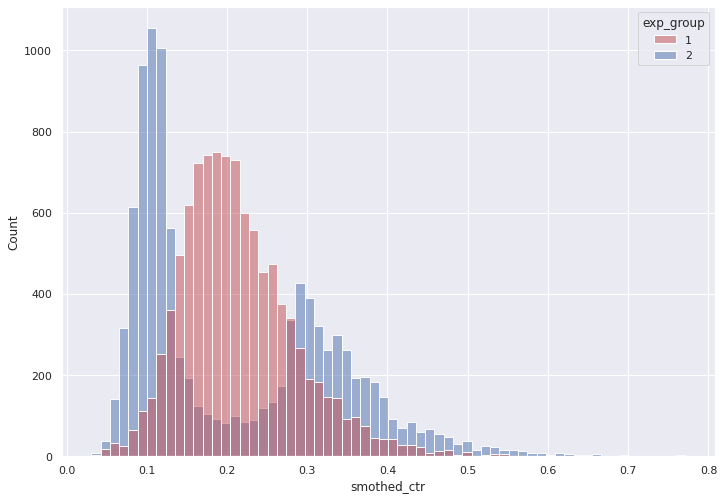

In [9]:
#установка размера гистограммы
sns.set(rc={'figure.figsize':(11.7,8.27)})

#отрисова гистограммы распределений ctr в группах 1 и 2
groups = sns.histplot(data = df, 
              x='smothed_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

В целом гистограммы сгладились, но на сестовой группе все еще очень явственно протупают 2 пика, листограмма выглядит перекошенной. Есть вероятность что результаты Т-теста все еще будут не адекватными.

In [10]:
#Т-тест для групп 1-2 по ctr 
stats.ttest_ind(df[df.exp_group == 1].smothed_ctr,
                df[df.exp_group == 2].smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

Т-тест на сглаженном CTR показал отличия. Причем отличия вероятно односторонние. И судя по гистограмме сглаженный CTR на тестовой группе меньше, чем на контрольной. Проверим предположение тестом Манна-Уитни

### Тест Манна-Уитни

Проверим предположение тестом *Манна-Уитни*.

Нулевая гипотеза $H_0: P(X_2>X_1) = P(X_1>X_2)$

Альтернативная гипотеза : $H_1: P(X_2<X_1) > P(X_1<X_2)$


In [11]:
#вывод на экран результатов теста Манна - Уинтни для односторонней гитотезы, проверка LESS
print(stats.mannwhitneyu(x = df[df.exp_group == 2].ctr,
                y = df[df.exp_group == 1].ctr, alternative = 'less'))

#подсчет процентного отношения случаев, когда в группе 1 CTR больше чем в группе 2.
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев CTR в Контрольной группе больше, чем в Тестовой группе')

MannwhitneyuResult(statistic=43704947.5, pvalue=3.0188242308889518e-56)
В 56.42 % случаев CTR в Контрольной группе больше, чем в Тестовой группе


Альтернативная гипотеза подтвердилась. Значение pvalue = 3.0188242308889518e-56 менее чем 0.025. Значит альтернативаня гипотеза продтвердилась. CTR в группе А примерно в 56% случаем больше чем в группе 2.

### Пуассоновский бутстеп

Контрольно проведем еще несколько тестов. Первый из них Пуасоновский Бутсреп. Подготовим функцию для Пуасоновского бутстрепа.

In [12]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    '''
    Функция на фход получает лайки и просмотры обоих групп, а так же число итераций,
    Генерирует сколько раз пользователь попал в конкретную подвыборку
    Далее счтает распределение Global CTR для тестовой и контрольной группы
    И возвражает новые распределения.
    '''
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

Подготовим переменные и запустим Бутсреп.

In [13]:
#подготовка переменных для бутсрепа
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

#запуск пуасоновского бутсрепа
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

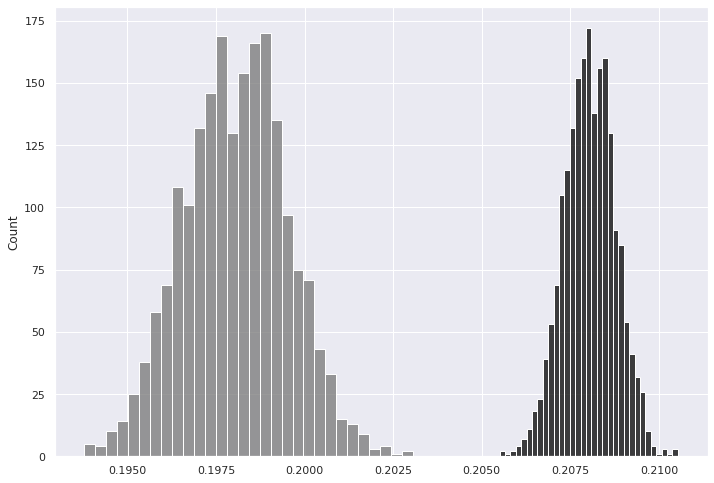

In [14]:
#Отрисовка графиков бутсрепа
sns.histplot(ctr1, color = '#000000') #черный
sns.histplot(ctr2, color = '#777777') #серый

Можно заметить, что у тестовой (серая) и контрольной (черная) групп нет пересечений. К тому же тестовая очевидным образом имеет более малые значения, чем контрольная. Мы можем сделать вывод, что новый алгоритм работает хуже, чем алгоритм контрольной группы.

### Бакетное преобразование

Подготовим новую талицу с бакетами. Для этого сделаем новый запрос SQL.

In [15]:
#новый SQL запрос
q = """SELECT exp_group,
              bucket,
              sum(likes)/sum(views) as bucket_ctr
       FROM (SELECT exp_group, 
                    xxHash64(user_id)%50 as bucket,
                    user_id,
                    sum(action = 'like') as likes,
                    sum(action = 'view') as views
             FROM simulator_20220620.feed_actions 
             WHERE toDate(time) between '2022-05-24' and '2022-05-30'
                   and exp_group in (1,2)
             GROUP BY exp_group, bucket, user_id)
        GROUP BY exp_group, bucket"""

#получение данных из clickhouse
df_bucket = pandahouse.read_clickhouse(q, connection=connection)

#вывод первых пяти строк данных
print(df_bucket.head())

   exp_group  bucket  bucket_ctr
0          1       0    0.196481
1          2       0    0.194262
2          1       1    0.211887
3          2       1    0.215328
4          1       2    0.206271


Построим гистограмму для бакетов.

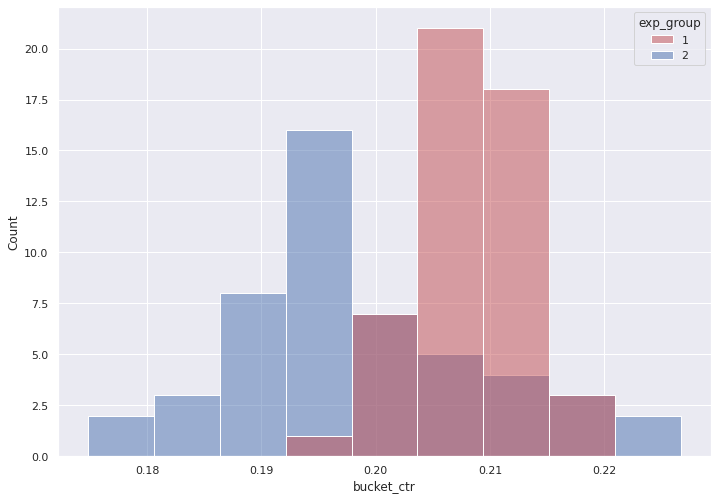

In [16]:
#установка размера гистограммы
sns.set(rc={'figure.figsize':(11.7,8.27)})

#отрисова гистограммы распределений ctr в группах 1 и 2
groups = sns.histplot(data = df_bucket, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Уже по гистограмме видно, что группы отличаются. Проведем Т-тест и тест Манна-Уитни.

#### Т-тест для бакетного преобразования

Нулевая гипотеза: $H_0:\mu_1 = \mu_2$

Альтернативная гипотеза: $H_1:\mu_1 \neq \mu_2$

In [17]:
#Т-тест для групп 1-2 по ctr 
stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr,
                df_bucket[df_bucket.exp_group == 2].bucket_ctr,
                equal_var=False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

По результату можно видеть, что группы отличаются друг от друга. Значение p-value очень мало.

#### Тест Манна-Уитни для бакетного преобразования

Нулевая гипотеза $H_0: P(X_2>X_1) = P(X_1>X_2)$

Альтернативная гипотеза : $H_1: P(X_2<X_1) > P(X_1<X_2)$

In [18]:
#вывод на экран результатов теста Манна - Уинтни для односторонней гитотезы, проверка LESS
print(stats.mannwhitneyu(x = df_bucket[df_bucket.exp_group == 2].bucket_ctr,
                y = df_bucket[df_bucket.exp_group == 1].bucket_ctr, alternative = 'less'))

MannwhitneyuResult(statistic=505.0, pvalue=1.429981968246323e-07)


Как и при предыдущем тесте Манна-Уитни предположение, что результаты в тестовой группе хуже чем результаты в контрольной подтвердились.

### Вывод

Т-тест при распределениях сильно отличных от нормального, тем более со скосами может выдавать не самые адекватные результаты. Остальные тесты (тест Манна-Уитни, Пуассоновский бутсреп, Т_тест на сглаженном CTR, и тесты на бакетном преобразовании) достаточно хорошо справляюся с поодобными проблемами.

## Анализ ситуации

Распределение с 2 пиками вероятно возникло из-за того, что модель в своих предсказаниях отдает предпочтение интересам одной группы пользователей в ущерб другой, возможно у модели предсказание близко к константному. 

Для примера, если у нас есть  предположим три группы интересов пользователей: кулинария, спорт, дети. Если всем пользователям мы начнем чаще предсказывать интерес - спорт, то мы получим увеличение CTR в группе спорт и падение CTR в остальных группах.

## Вывод

Новый алгоритм однозначно **нельзя рекомендовать для всех пользователей**. Алгоритм, как минимум, требует серьезной доработки и в данном виде **не подходит для внедрения**. 